23 October 2018

# UK Gap Analysis

This notebook contains a gap analysis of GBIF Specimens from the United Kingdom.

## 1. Import the required Python libraries

In [1]:
import numpy as np
import pandas as pd
import reverse_geocoder as rg
from pandas.api.types import CategoricalDtype
%matplotlib inline

## 2. Download GBIF dataset

From the GBIF Occurrence Search page (https://www.gbif.org/occurrence/search), search for all records where:  
`Basis of record = Preserved specimen, Material sample`  
`Country = United Kingdom, Ireland`  

Download the dataset. Dataset citation: 
> GBIF.org (22 October 2018) GBIF Occurrence Download https://doi.org/10.15468/dl.pdpekf

File saved as **gbif_uk_specimens_20181022.csv**  
1,365,100 records

In [2]:
gbif_file = 'gbif_uk_specimens_20181022.csv'

## 3. Extract distinct families (+ higher taxa) with valid lat-long coordinates

Import GBIF CSV file (specified above)

In [3]:
gbif_all = pd.read_csv(gbif_file, sep="\t", dtype='str')

In [7]:
gbif_all.columns

Index(['gbifID', 'datasetKey', 'occurrenceID', 'kingdom', 'phylum', 'class',
       'order', 'family', 'genus', 'species', 'infraspecificEpithet',
       'taxonRank', 'scientificName', 'countryCode', 'locality',
       'publishingOrgKey', 'decimalLatitude', 'decimalLongitude',
       'coordinateUncertaintyInMeters', 'coordinatePrecision', 'elevation',
       'elevationAccuracy', 'depth', 'depthAccuracy', 'eventDate', 'day',
       'month', 'year', 'taxonKey', 'speciesKey', 'basisOfRecord',
       'institutionCode', 'collectionCode', 'catalogNumber', 'recordNumber',
       'identifiedBy', 'dateIdentified', 'license', 'rightsHolder',
       'recordedBy', 'typeStatus', 'establishmentMeans', 'lastInterpreted',
       'mediaType', 'issue'],
      dtype='object')

From data, select distinct `kingdom`, `phylum`, `class`, `order`, `family`, `decimalLatitude`, `decimalLongitude`.

In [8]:
recs = gbif_all[['kingdom', 'phylum', 'class', 'order', 'family', 'decimalLatitude', 'decimalLongitude']].copy()
recs = recs.fillna('')
recs = recs.drop_duplicates()

Filter the data; select only records with numeric lat/long values, and remove records with no taxonomic information.

In [10]:
def numericcoords(x):
    for coord in [x['decimalLatitude'], x['decimalLongitude']]:
        if coord == '':
            return False
        try:
            pd.to_numeric(coord)
        except ValueError:
            return False
    return True

recs['valid'] = recs.apply(lambda x: numericcoords(x), axis=1)
recs = recs[recs.valid == True]
recs = recs.loc[:, 'kingdom':'decimalLongitude']

blanktaxa = (recs['kingdom'] == '') & \
    (recs['phylum'] == '') & \
    (recs['class'] == '') & \
    (recs['order'] == '') & \
    (recs['family'] == '')
recs = recs[~blanktaxa]
print('{} records with valid coordinates found'.format(recs.shape[0]))

94647 records with valid coordinates found


In [11]:
recs.head()

,kingdom,phylum,class,order,family,decimalLatitude,decimalLongitude
3,Plantae,Rhodophyta,Florideophyceae,Corallinales,Hapalidiaceae,51.7367,-5.2433
5,Animalia,Arthropoda,Malacostraca,Isopoda,Idoteidae,56.37,-2.83
6,Animalia,Mollusca,Gastropoda,Littorinimorpha,Littorinidae,52.65,1.67
18,Plantae,Rhodophyta,Florideophyceae,Corallinales,Corallinaceae,50.32,-4.13
24,Animalia,Echinodermata,Asteroidea,Valvatida,Solasteridae,56.5083,-5.4528


Export the filtered data file so that it can be added to Dropbox. (The original GBIF file is too huge!)

In [12]:
recs_file = 'gbif_uk_families.csv'

In [13]:
recs.to_csv(recs_file, index=False, sep='\t')

## 4. Geocode records and filter out non-UK records

(Re-)import the GBIF records from the file exported in the last step.

In [14]:
recs = pd.read_csv(recs_file, sep='\t', dtype='str')

Convert string columns `decimalLatitude` and `decimalLongitude` to numeric columns `latitude` and `longitude` respectively.

In [15]:
recs['decimalLatitude'] = pd.to_numeric(recs['decimalLatitude'])
recs['decimalLongitude'] = pd.to_numeric(recs['decimalLongitude'])
recs = recs.rename(columns={'decimalLatitude': 'latitude', 'decimalLongitude': 'longitude'})

Rough plot of `latitude` and `longitude`

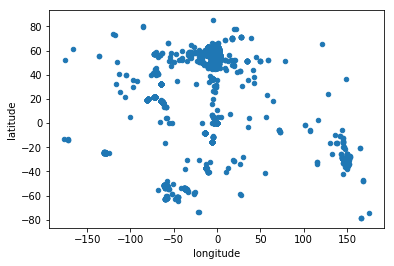

In [16]:
plotdata = {'latitude': recs.latitude, 'longitude': recs.longitude}
coordmap = pd.DataFrame(data=plotdata)
coordmap.plot.scatter(x='longitude', y='latitude');

Although these samples are supposed to be from the United Kingdom only, coordinates are present all around the globe. Highest concentrations seem to be in Western Europe, Australia, and the Southern Atlantic/Antarctica.

### 4a. reverse_geocoder

GeoNames.org is a website that provides reverse-geocoding of lat/long coordinates to country names, etc. There is a Python library, `reverse_geocoder` (imported as `rg`), that allows users to query the GeoNames database without making API calls.

*(Note, the latitude and longitude returned from rg are not the same as the ones supplied. reverse_geocoder finds the nearest city to the coordinates supplied, then provides the coordinates of that city. Don't use the returned lat/lon as the ones provided.)*

reverse_geocoder requires a (latitude, longitude) tuple to geocode. Added a column, `coordinate`, containing this tuple.

In [17]:
recs['coordinate'] = recs.apply(lambda row: (row['latitude'], row['longitude']), axis=1)
recs.head()

,kingdom,phylum,class,order,family,latitude,longitude,coordinate
0,Plantae,Rhodophyta,Florideophyceae,Corallinales,Hapalidiaceae,51.7367,-5.2433,"(51.7367, -5.2433)"
1,Animalia,Arthropoda,Malacostraca,Isopoda,Idoteidae,56.3700,-2.8300,"(56.37, -2.83)"
2,Animalia,Mollusca,Gastropoda,Littorinimorpha,Littorinidae,52.6500,1.6700,"(52.65, 1.67)"
3,Plantae,Rhodophyta,Florideophyceae,Corallinales,Corallinaceae,50.3200,-4.1300,"(50.32, -4.13)"
4,Animalia,Echinodermata,Asteroidea,Valvatida,Solasteridae,56.5083,-5.4528,"(56.5083, -5.4528)"


For efficiency, isolate a list of unique coordinates (`ucoords`) to be reverse geocoded.

In [18]:
# https://gist.github.com/bsweger/e5817488d161f37dcbd2
ucoords = pd.unique(recs.coordinate.ravel()).tolist()
print(len(ucoords), "unique coordinates")

36441 unique coordinates


Reverse geocode the list of ucoords to obtain the country code, administrative district 1, and administrative district 2. Then add the ucoord back to the result. Create a DataFrame, `geolocs`, from the rg results. For ease of joining in the next step, the ucoord is set as the index for this df.

In [20]:
results = rg.search(ucoords)
gl = []

for r in results:
    x = {}
    x['cc'] = r['cc']
    x['admin1'] = r['admin1']
    gl.append(x)

for x in range(len(gl)):
    gl[x]['lat_lon'] = ucoords[x]
      
geolocs = pd.DataFrame.from_records(gl, columns = ['lat_lon', 'cc', 'admin1'], index='lat_lon')
geolocs.head()

,cc,admin1
lat_lon,,
"(51.7367, -5.2433)",GB,Wales
"(56.37, -2.83)",GB,Scotland
"(52.65, 1.67)",GB,England
"(50.32, -4.13)",GB,England
"(56.5083, -5.4528)",GB,Scotland


### 4b. Join geolocs to recs to obtain country code and admin1 for each taxon

In [21]:
georecs = recs.join(
    geolocs, 
    on = 'coordinate', 
    how = 'left'
)
georecs.head()

,kingdom,phylum,class,order,family,latitude,longitude,coordinate,cc,admin1
0,Plantae,Rhodophyta,Florideophyceae,Corallinales,Hapalidiaceae,51.7367,-5.2433,"(51.7367, -5.2433)",GB,Wales
1,Animalia,Arthropoda,Malacostraca,Isopoda,Idoteidae,56.3700,-2.8300,"(56.37, -2.83)",GB,Scotland
2,Animalia,Mollusca,Gastropoda,Littorinimorpha,Littorinidae,52.6500,1.6700,"(52.65, 1.67)",GB,England
3,Plantae,Rhodophyta,Florideophyceae,Corallinales,Corallinaceae,50.3200,-4.1300,"(50.32, -4.13)",GB,England
4,Animalia,Echinodermata,Asteroidea,Valvatida,Solasteridae,56.5083,-5.4528,"(56.5083, -5.4528)",GB,Scotland


Filter records to just those from Great Britain (GB; includes England, Northern Ireland, Scotland, and Wales) and Ireland (IE)

In [22]:
uk = georecs[(georecs['cc'] == 'GB') | (georecs['cc'] == 'IE')].copy()

Determine the `admin1` areas found in Ireland.

In [23]:
gb_admin1 = sorted(list(georecs[georecs['cc'] == 'GB'].admin1.unique()))
ie_admin1 = sorted(list(georecs[georecs['cc'] == 'IE'].admin1.unique()))
print('GB admin1 areas: {}'.format(gb_admin1))
print('IE admin1 areas: {}'.format(ie_admin1))

GB admin1 areas: ['England', 'Northern Ireland', 'Scotland', 'Wales']
IE admin1 areas: ['', 'Connaught', 'Leinster', 'Munster', 'Ulster']


### 4c. Assign `country` value to each record

For records from Great Britain, the admin1 area is the actual country name (England, Northern Ireland, Scotland, Wales). For records from Ireland, the admin1 area is the county (Connacht, Leinster, Munster, Ulster). I would like to create a map at the country level, so I am going to add a column `country` that translates records to one of five countries: England, Northern Ireland, Scotland, Wales, and Ireland.

In [24]:
def assigncountry(admin1):
    if admin1 in gb_admin1:
        return admin1
    elif admin1 in ie_admin1:
        return 'Ireland'
    

uk['country'] = uk['admin1'].apply(assigncountry)
uk.head(10)

,kingdom,phylum,class,order,family,latitude,longitude,coordinate,cc,admin1,country
0,Plantae,Rhodophyta,Florideophyceae,Corallinales,Hapalidiaceae,51.7367,-5.2433,"(51.7367, -5.2433)",GB,Wales,Wales
1,Animalia,Arthropoda,Malacostraca,Isopoda,Idoteidae,56.3700,-2.8300,"(56.37, -2.83)",GB,Scotland,Scotland
2,Animalia,Mollusca,Gastropoda,Littorinimorpha,Littorinidae,52.6500,1.6700,"(52.65, 1.67)",GB,England,England
3,Plantae,Rhodophyta,Florideophyceae,Corallinales,Corallinaceae,50.3200,-4.1300,"(50.32, -4.13)",GB,England,England
4,Animalia,Echinodermata,Asteroidea,Valvatida,Solasteridae,56.5083,-5.4528,"(56.5083, -5.4528)",GB,Scotland,Scotland
5,Animalia,Mollusca,Bivalvia,Pectinida,Pectinidae,60.5000,-1.0000,"(60.5, -1.0)",GB,Scotland,Scotland
8,Animalia,Arthropoda,Malacostraca,Decapoda,Sergestidae,56.3000,-16.5500,"(56.3, -16.55)",IE,Connaught,Ireland
9,Plantae,Rhodophyta,Florideophyceae,Corallinales,Corallinaceae,50.3000,-4.0800,"(50.3, -4.08)",GB,England,England
10,Animalia,Mollusca,Gastropoda,Littorinimorpha,Littorinidae,57.2800,-0.4300,"(57.28, -0.43)",GB,Scotland,Scotland
12,Animalia,Mollusca,Bivalvia,Pectinida,Pectinidae,56.4300,-5.4700,"(56.43, -5.47)",GB,Scotland,Scotland


Clean up DataFrame - remove redundant `coordinate` column, move `country`.

In [25]:
uk = uk[['kingdom', 'phylum', 'class', 'order', 'family', 
         'country', 'latitude', 'longitude', 'cc', 'admin1']]
uk.head()

,kingdom,phylum,class,order,family,country,latitude,longitude,cc,admin1
0,Plantae,Rhodophyta,Florideophyceae,Corallinales,Hapalidiaceae,Wales,51.7367,-5.2433,GB,Wales
1,Animalia,Arthropoda,Malacostraca,Isopoda,Idoteidae,Scotland,56.3700,-2.8300,GB,Scotland
2,Animalia,Mollusca,Gastropoda,Littorinimorpha,Littorinidae,England,52.6500,1.6700,GB,England
3,Plantae,Rhodophyta,Florideophyceae,Corallinales,Corallinaceae,England,50.3200,-4.1300,GB,England
4,Animalia,Echinodermata,Asteroidea,Valvatida,Solasteridae,Scotland,56.5083,-5.4528,GB,Scotland


Save geocoded data to a CSV file

In [26]:
uk_taxa_file = 'uk_taxa_geos.csv'

In [27]:
uk.to_csv(uk_taxa_file, sep = '\t', index=False)

## 5. Counts of KPCOF in each country

Re-import country data from CSV file

In [28]:
uk = pd.read_csv(uk_taxa_file, sep='\t', dtype='str')
uk['latitude'] = pd.to_numeric(uk['latitude'])
uk['longitude'] = pd.to_numeric(uk['longitude'])
uk.head()

,kingdom,phylum,class,order,family,country,latitude,longitude,cc,admin1
0,Plantae,Rhodophyta,Florideophyceae,Corallinales,Hapalidiaceae,Wales,51.7367,-5.2433,GB,Wales
1,Animalia,Arthropoda,Malacostraca,Isopoda,Idoteidae,Scotland,56.3700,-2.8300,GB,Scotland
2,Animalia,Mollusca,Gastropoda,Littorinimorpha,Littorinidae,England,52.6500,1.6700,GB,England
3,Plantae,Rhodophyta,Florideophyceae,Corallinales,Corallinaceae,England,50.3200,-4.1300,GB,England
4,Animalia,Echinodermata,Asteroidea,Valvatida,Solasteridae,Scotland,56.5083,-5.4528,GB,Scotland


Calculate total counts of KPCOF in UK/Ireland

In [29]:
counts_total = uk[['kingdom', 'phylum', 'class', 'order', 'family']].agg(pd.Series.nunique)
counts_total

kingdom       7
phylum       49
class       138
order       662
family     2751
dtype: int64

Calculate total counts of KPCOF by country

In [30]:
counts_country = uk[['country', 'kingdom', 'phylum', 'class', 'order', 'family']] \
                   .groupby('country') \
                   .agg(pd.Series.nunique)
counts_country

,kingdom,phylum,class,order,family
country,,,,,
England,7,41,127,596,2257
Ireland,6,16,44,128,345
Northern Ireland,5,22,48,132,233
Scotland,7,40,111,465,1656
Wales,6,29,82,291,834


## 6. GGBN

For each of the countries, we want an idea of how many of their KPCOF are currently in GGBN versus not. 

GGBN data are available through the GGBN Data Portal API. A Gist on querying the API is available here: https://gist.github.com/amdevine/b21ca15fcfaac5c1e75fc33fdcde4056. I use a Python script to retrieve the data and save it as a text file.

Import latest GGBN download file, cleaned and standardized to the CoL backbone taxonomy.

In [31]:
ggbn_file = 'GGBN Download 2018-10-01.tsv'

In [32]:
ggbn_all = pd.read_csv(ggbn_file, sep='\t', dtype='str').fillna('xxxxxxxxxxxxxx')
ggbn = ggbn_all.loc[:, 'kingdom':'family'] \
               .drop_duplicates() \
               .sort_values(['kingdom', 'phylum', 'class', 'order', 'family'])
ggbn.head()

,kingdom,phylum,class,order,family
3937,Animalia,Acanthocephala,Palaeacanthocephala,Echinorhynchida,Rhadinorhynchidae
497,Animalia,Acanthocephala,Palaeacanthocephala,Echinorhynchida,xxxxxxxxxxxxxx
200,Animalia,Acanthocephala,Palaeacanthocephala,xxxxxxxxxxxxxx,xxxxxxxxxxxxxx
7,Animalia,Acanthocephala,xxxxxxxxxxxxxx,xxxxxxxxxxxxxx,xxxxxxxxxxxxxx
2247,Animalia,Annelida,Clitellata,Arhynchobdellida,Erpobdellidae


Create a second table containing whether the KPCOF are in GGBN (`True`) or not (`False`)

In [34]:
inggbn = uk.loc[:, 'kingdom':'country']
inggbn['k'] = uk['kingdom'].isin(ggbn.kingdom)
inggbn['p'] = uk['phylum'].isin(ggbn.phylum)
inggbn['c'] = uk['class'].isin(ggbn['class'])
inggbn['o'] = uk['order'].isin(ggbn['order'])
inggbn['f'] = uk['family'].isin(ggbn.family)
inggbn.head(20)

,kingdom,phylum,class,order,family,country,k,p,c,o,f
0,Plantae,Rhodophyta,Florideophyceae,Corallinales,Hapalidiaceae,Wales,True,True,True,True,True
1,Animalia,Arthropoda,Malacostraca,Isopoda,Idoteidae,Scotland,True,True,True,True,True
2,Animalia,Mollusca,Gastropoda,Littorinimorpha,Littorinidae,England,True,True,True,True,True
3,Plantae,Rhodophyta,Florideophyceae,Corallinales,Corallinaceae,England,True,True,True,True,True
4,Animalia,Echinodermata,Asteroidea,Valvatida,Solasteridae,Scotland,True,True,True,True,True
5,Animalia,Mollusca,Bivalvia,Pectinida,Pectinidae,Scotland,True,True,True,True,True
6,Animalia,Arthropoda,Malacostraca,Decapoda,Sergestidae,Ireland,True,True,True,True,True
7,Plantae,Rhodophyta,Florideophyceae,Corallinales,Corallinaceae,England,True,True,True,True,True
8,Animalia,Mollusca,Gastropoda,Littorinimorpha,Littorinidae,Scotland,True,True,True,True,True
9,Animalia,Mollusca,Bivalvia,Pectinida,Pectinidae,Scotland,True,True,True,True,True


Calculated the total number of families in the UK/Ireland that are in GGBN

In [35]:
total_ggbn_families = inggbn[['family', 'f']].drop_duplicates()
total_ggbn_families = sum(total_ggbn_families.f)
print('There are {} families in UK/Ireland that are in GGBN.'.format(total_ggbn_families))

There are 1567 families in UK/Ireland that are in GGBN.


Create summary table with counts of KPCOF in GGBN for each country

In [36]:
kingdoms = inggbn[['country', 'kingdom', 'k']].drop_duplicates()
kingdoms = kingdoms[['country', 'k']].groupby('country').agg(sum)
phyla = inggbn[['country', 'phylum', 'p']].drop_duplicates()
phyla = phyla[['country', 'p']].groupby('country').agg(sum)
classes = inggbn[['country', 'class', 'c']].drop_duplicates()
classes = classes[['country', 'c']].groupby('country').agg(sum)
orders = inggbn[['country', 'order', 'o']].drop_duplicates()
orders = orders[['country', 'o']].groupby('country').agg(sum)
families = inggbn[['country', 'family', 'f']].drop_duplicates()
families = families[['country', 'f']].groupby('country').agg(sum)

In [37]:
in_ggbn = pd.merge(kingdoms, phyla, on='country')
in_ggbn = pd.merge(in_ggbn, classes, on='country')
in_ggbn = pd.merge(in_ggbn, orders, on='country')
in_ggbn = pd.merge(in_ggbn, families, on='country')
in_ggbn.columns = ['kingdom', 'phylum', 'class', 'order', 'family']
in_ggbn = pd.DataFrame(in_ggbn.to_records())
in_ggbn

,country,kingdom,phylum,class,order,family
0,England,6.0,31.0,100.0,395.0,1374.0
1,Ireland,5.0,16.0,41.0,102.0,224.0
2,Northern Ireland,5.0,19.0,41.0,106.0,172.0
3,Scotland,6.0,31.0,90.0,335.0,1040.0
4,Wales,6.0,26.0,69.0,212.0,568.0


"Un-pivot" the GGBN data into one column, to be added to results later

In [38]:
in_ggbn = pd.melt(in_ggbn, 
                  id_vars=['country'], 
                  value_vars=['kingdom', 'phylum', 'class', 'order', 'family'],
                  var_name='taxrank',
                  value_name='countggbn',
                 ).drop_duplicates()
cattype = CategoricalDtype(categories=['kingdom', 'phylum', 'class', 'order', 'family'], ordered=True)
in_ggbn['taxrank'] = in_ggbn['taxrank'].astype(cattype)
in_ggbn['countggbn'] = in_ggbn['countggbn'].astype('int32', copy=False)
in_ggbn = in_ggbn.sort_values(['country', 'taxrank'])
in_ggbn

,country,taxrank,countggbn
0,England,kingdom,6
5,England,phylum,31
10,England,class,100
15,England,order,395
20,England,family,1374
1,Ireland,kingdom,5
6,Ireland,phylum,16
11,Ireland,class,41
16,Ireland,order,102
21,Ireland,family,224


## 7. Catalogue of Life

We also want to look at the percent of life on Earth available in the UK and Ireland. For our backbone taxonomy, we are using the **Catalogue of Life, 24 September 2018** download available from the Darwin Core Archive Export (http://www.catalogueoflife.org/DCA_Export/archive.php) repository.

After light processing of this download, we are left with a file, **CoL Genera 2018-09-24.tsv**

In [39]:
col_file = 'CoL Genera 2018-09-24.tsv'

In [40]:
col_all = pd.read_csv(col_file, sep='\t', dtype='str').fillna('')

In [41]:
col = col_all.loc[:, 'kingdom':'family'] \
             .drop_duplicates() \
             .sort_values(['kingdom', 'phylum', 'class', 'order', 'family'])

Found the number of unique names for each taxonomic rank

In [42]:
col_counts = col.agg(pd.Series.nunique)
col_counts

kingdom       8
phylum      102
class       346
order      1446
family     9859
dtype: int64

## 8. Percentages of CoL taxa in each country

"Unpivot" the `uk` table. Leave country as a grouping variable, but gather all the taxonomic name columns into two columns: one column contains the taxonomic rank (`taxrank`), the other contains the taxonomic name (`taxname`).

In [43]:
taxcountries = pd.melt(uk, 
                       id_vars=['country'], 
                       value_vars=['kingdom', 'phylum', 'class', 'order', 'family'],
                       var_name='taxrank',
                       value_name='taxname',
                      ).drop_duplicates()
cattype = CategoricalDtype(categories=['kingdom', 'phylum', 'class', 'order', 'family'], ordered=True)
taxcountries['taxrank'] = taxcountries['taxrank'].astype(cattype)
taxcountries.head(10)

,country,taxrank,taxname
0,Wales,kingdom,Plantae
1,Scotland,kingdom,Animalia
2,England,kingdom,Animalia
3,England,kingdom,Plantae
6,Ireland,kingdom,Animalia
27,Northern Ireland,kingdom,Animalia
39,Scotland,kingdom,Plantae
44,Scotland,kingdom,Fungi
45,England,kingdom,Fungi
58,Wales,kingdom,Fungi


Aggregate the unpivoted data by country name and taxonomic rank, counting the unique elements for each country and taxrank.

In [44]:
tax_counts = taxcountries.groupby(['country', 'taxrank']).agg(pd.Series.nunique)
tax_counts = pd.DataFrame(tax_counts.to_records())
tax_counts = tax_counts.rename(columns={'taxname': 'ukcount'})
tax_counts

,country,taxrank,ukcount
0,England,kingdom,7
1,England,phylum,41
2,England,class,127
3,England,order,596
4,England,family,2257
5,Ireland,kingdom,6
6,Ireland,phylum,16
7,Ireland,class,44
8,Ireland,order,128
9,Ireland,family,345


Add the total taxrank counts found for the Catalogue of Life (`col_counts`)

In [45]:
tax_counts['colcount'] = tax_counts['taxrank'].apply(lambda x: col_counts[x])
tax_counts

,country,taxrank,ukcount,colcount
0,England,kingdom,7,8
1,England,phylum,41,102
2,England,class,127,346
3,England,order,596,1446
4,England,family,2257,9859
5,Ireland,kingdom,6,8
6,Ireland,phylum,16,102
7,Ireland,class,44,346
8,Ireland,order,128,1446
9,Ireland,family,345,9859


Create a column containing the percent of all CoL families found in that country and at that taxonomic rank in the UK and Ireland

In [46]:
tax_counts = tax_counts.assign(ukpercent=tax_counts.ukcount/tax_counts.colcount)
tax_counts

,country,taxrank,ukcount,colcount,ukpercent
0,England,kingdom,7,8,0.875000
1,England,phylum,41,102,0.401961
2,England,class,127,346,0.367052
3,England,order,596,1446,0.412172
4,England,family,2257,9859,0.228928
5,Ireland,kingdom,6,8,0.750000
6,Ireland,phylum,16,102,0.156863
7,Ireland,class,44,346,0.127168
8,Ireland,order,128,1446,0.088520
9,Ireland,family,345,9859,0.034993


Create columns containing the counts and percents of taxa in GGBN

In [47]:
tax_counts = pd.merge(tax_counts, in_ggbn, on=['country', 'taxrank'])
tax_counts = tax_counts.assign(percent_not_ggbn=(tax_counts.ukcount-tax_counts.countggbn)/tax_counts.ukcount)
tax_counts

,country,taxrank,ukcount,colcount,ukpercent,countggbn,percent_not_ggbn
0,England,kingdom,7,8,0.875000,6,0.142857
1,England,phylum,41,102,0.401961,31,0.243902
2,England,class,127,346,0.367052,100,0.212598
3,England,order,596,1446,0.412172,395,0.337248
4,England,family,2257,9859,0.228928,1374,0.391227
5,Ireland,kingdom,6,8,0.750000,5,0.166667
6,Ireland,phylum,16,102,0.156863,16,0.000000
7,Ireland,class,44,346,0.127168,41,0.068182
8,Ireland,order,128,1446,0.088520,102,0.203125
9,Ireland,family,345,9859,0.034993,224,0.350725


Export table with counts to TSV file

In [48]:
counts_file = 'uk_taxa_counts.tsv'

In [49]:
tax_counts.to_csv(counts_file, sep='\t', index=False)

## Results

Produced a map of UK/Ireland in Inkscape.

![](uk_ireland_map_small.png)